In [1]:
%load_ext autoreload

%autoreload 2

In [101]:
from __future__ import division
from glob import glob
import os
import time
import cPickle as pickle

import scipy.linalg
import scipy.stats

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc("figure", dpi=144)

import astropy.io.fits
import astropy.table
import astropy.units as u
import astropy.constants as c
import astropy.time

import emcee
import numdifftools

import kepler
import threebody

In [3]:
!ls -ltr *.tim

-rw-r--r-- 1 aarchiba aipsuser     3194 May 31  2013 0337-short-2.tim
-rw-r--r-- 1 aarchiba aipsuser  1709289 May 31  2013 0337+17.tim
-rw-r--r-- 1 aarchiba aipsuser    10646 May 31  2013 0337-short.tim
-rw-r--r-- 1 aarchiba aipsuser  1870476 Jun 17  2013 0337+17-scott-2013-06-06.tim
-rw-r--r-- 1 aarchiba aipsuser  6961347 Jul 31  2013 synthetic.tim
-rw-r--r-- 1 aarchiba aipsuser  1977505 Aug 15  2013 0337+17-scott-2013-08-15.tim
-rw-r--r-- 1 aarchiba aipsuser  2043963 Aug 30  2013 0337+17-scott-2013-08-29.tim
-rw-r--r-- 1 aarchiba aipsuser  1590000 Sep 19  2013 fake-pulsar.tim
-rw-r--r-- 1 aarchiba aipsuser  2078907 Jan 22  2014 0337+17-scott-2014-01-22.tim
-rw-r--r-- 1 aarchiba aipsuser  2201549 Jan 28  2014 0337+17-anne-2014-01-28.tim
-rw-r--r-- 1 aarchiba aipsuser      154 Feb  4  2014 0337+17-anne-2014-02-04.tim
-rw-r--r-- 1 aarchiba aipsuser  2186806 Feb  4  2014 0337+17-anne-2014-02-04b.tim
-rw-r--r-- 1 aarchiba aipsuser  2143978 Feb 10  2014 fake-t2.tim
-rw-r--r-- 1 aarchiba ai

In [4]:
!ls -ltr toas/*/*.tim

-rw-r--r-- 1 aarchiba aipsuser 2078907 Jan 22  2014 toas/gbt/0337+17-scott-2014-01-22.tim
-rw-r--r-- 1 aarchiba aipsuser  898938 Feb  4  2014 toas/gbt/L-band-scott-2014-02-04.tim
-rw-rw-r-- 1 aarchiba aipsuser  174978 Feb  4  2014 toas/wsrt/L-band-anne-2014-02-04.tim
-rw-rw-r-- 1 aarchiba aipsuser 1112898 Feb  4  2014 toas/ao/L-band-anne-2014-02-04.tim
-rw-r--r-- 1 aarchiba aipsuser  898928 Feb 12  2014 toas/gbt/L-band-scott-2014-02-04-nojump.tim
-rw-rw-r-- 1 aarchiba aipsuser  116372 Mar 19  2014 toas/gbt/L-band-2d-scott-2014-03-03.tim
-rw-r----- 1 aarchiba aipsuser 1116480 Sep 22  2014 toas/gbt/L-band-scott-2014-08-12.tim


In [54]:
# If we're using tempo1 format files the loader can correctly identify telescope and band
# So really we're just concatenating these files
timfiles = [
    ['0337+1715_GUPPI_Lband_fscr_t1.tim', 'GBT1500'],
    ['toas/wsrt/L-band-anne-2014-02-04.tim', 'WSRT1400'],
    ['toas/ao/L-band-anne-2014-02-04.tim','AO1350'],
    ]
outname = '0337+17-anne-2016-09-26'

firstchars = {}
with open(outname+".tim", "wt") as f:
    for (t,tel) in timfiles:
        f.write("C %s\n" % t)
    for (t,tel) in timfiles:
        skipping = False
        for l in open(t,"rt").readlines():
            if l.startswith("SKIP"):
                if skipping: 
                    raise ValueError
                skipping = True
            elif l.startswith("NOSKIP"):
                if not skipping: 
                    raise ValueError
                skipping = False
            elif l.startswith("EMAX"):
                pass
            else:
                # Maybe strip comments?
                if not skipping:
                    if l[0] not in firstchars:
                        firstchars[l[0]] = 0
                    firstchars[l[0]] += 1
                    f.write(l)
        if skipping: 
            raise ValueError
firstchars, firstchars['1']+firstchars['3']+firstchars['j']

({'1': 18443, '3': 15202, 'C': 52, 'J': 2, 'T': 2, 'j': 2243}, 35888)

## Assign pulse numbers using a three-body solution

In [5]:
fpickle = "forecaster_params.pickle"
d = pickle.load(open(fpickle,"rb"))
F = threebody.Fitter(**d)
d

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': '0337+17-anne-2014-09-22',
 'fit_pm': False,
 'fit_pos': True,
 'fit_px': False,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'tzrmjd_middle': False}

In [6]:
# FIXME: jumps
o = threebody.compute_orbit(F.best_parameters, F.mjds)

In [7]:
t_psr_s = o['t_psr']*86400
p = F.best_parameters
tzrmjd_base = p['tzrmjd_base']
tzrmjd_s = (p['tzrmjd']+(tzrmjd_base-F.base_mjd))*86400
phase = p['f0']*t_psr_s+p['f1']*t_psr_s**2/2.
phase -= p['f0']*tzrmjd_s+p['f1']*tzrmjd_s**2/2.

0 questionable entries


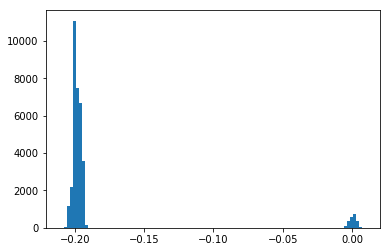

In [8]:
plt.hist(phase-np.round(phase),bins=100)
print np.sum(np.abs(phase-np.round(phase)>0.3)), "questionable entries"

In [9]:
F.derivs

{'d_DECJ': array([-113.15066, -113.1508, -113.15095, ...,  118.85497,  118.85498,
         118.85499], dtype=float128),
 'd_PMDEC': array([ 61874.24,  61874.278,  61874.316, ...,  44893.658,  44893.705,
         44893.741], dtype=float128),
 'd_PMRA': array([ 234600.09,  234600.5,  234600.9, ...,  174843.07,  174843.42,
         174843.69], dtype=float128),
 'd_PX': array([ 1.0426218e-06,  1.0426267e-06,  1.0426317e-06, ...,  1.2098231e-06,
         1.2098256e-06,  1.2098274e-06], dtype=float128),
 'd_RAJ': array([-429.01788, -429.0189, -429.01991, ...,  462.89317,  462.89367,
         462.89405], dtype=float128)}

In [10]:
F.best_parameters

{'acosi_i': 1.4917920737881377967,
 'acosi_o': 91.515517821405981132,
 'asini_i': 1.2175268187146886046,
 'asini_o': 74.672709901274213484,
 'd_DECJ': 3.8297379260835209625e-07,
 'd_RAJ': -9.1473641598984196357e-08,
 'dbeta': 3.137215781113322372e-05,
 'delta': -2.4326288381809617149e-10,
 'delta_lan': -5.4096316391090949558e-05,
 'dgamma': -2.5854449182822343408e-07,
 'eps1_i': 0.00068724728071223587401,
 'eps1_o': 0.035186247652040840626,
 'eps2_i': -9.1179836780626676656e-05,
 'eps2_o': -0.003462135260726911092,
 'f0': 365.95336311711874974,
 'f1': -2.3547358099625887817e-15,
 'j_AO1350': 5.364017648361716e-05,
 'j_AO1440': -0.00055121663140921818248,
 'j_AO327': 6.457616019511097e-05,
 'j_GBT1500': -0.00053763724410558742536,
 'j_GBT350': 1.8912917353649655e-05,
 'j_GBT820': 6.712253154451129e-05,
 'j_NCY1400': 0.000675,
 'j_WSRT350': -3.6063906052781444e-05,
 'pb_i': 1.6293969394546642386,
 'pb_o': 327.2575252205244358,
 'ppn_mode': 'heavysimple',
 'q_i': 0.13746673219074406775,
 

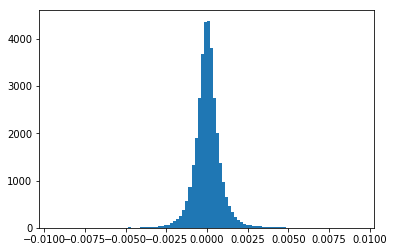

In [11]:
r = F.residuals(F.best_parameters)
plt.hist(r, bins=100);

In [47]:
d_new = d.copy()
d_new['files'] = outname
d_new

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': '0337+17-anne-2016-09-26',
 'fit_pm': False,
 'fit_pos': True,
 'fit_px': False,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'tzrmjd_middle': False}

In [53]:
F_new = threebody.Fitter(**d_new)

ValueError: Confusing tim file 0337+17-anne-2016-09-26.tim: list of 35888 telescope codes doesn't match list of 35814 BATs

In [ ]:
r = F_new.residuals(F.best_parameters)
plt.hist(r, bins=100);

## Loading in pipeline tim files

In [19]:
toa_info = threebody.read_t2_toas("onescintle_mueller.tim")
nopulses = 0
for t in toa_info:
    if "pn" not in t["flags"]:
        nopulses += 1
print nopulses, "/", len(toa_info), "missing pulse numbers"

78219 / 78219 missing pulse numbers


In [17]:
toa_info[0]['flags']

{'file': 'data/obs/55956.63_WSRT_1400/onescintle/scrunch_0000.ar',
 'flags': {'P': '0.00273289117052',
  'band': '1400',
  'bw': '5.0',
  'chan': '0',
  'max_smearing': '0.0369982444476',
  'nbin': '512',
  'phase': '-0.234572279593',
  'processing_name': 'onescintle',
  'reduced_chi2': '0.972311607627',
  'snr': '0.127812757608',
  'subint': '0',
  'tel': 'WSRT',
  'toa_name': 'mueller',
  'tsubint': '589.996224',
  'uncert': '0.00248540565308',
  'uncert_scaled': '0.00245075567541',
  'weighted_frequency': '1380.00004345'},
 'freq': 1302.5,
 'mjd': 55956.633159781646,
 'mjd_string': '55956.63315978164554953533',
 'tel': 'wsrt',
 'uncert': 6.79234316447}

In [22]:
threebody.load_pipeline_toas(timfile="onescintle_mueller.tim", t2outfile="onescintle_mueller.out")

(array([ 55956.636,  55956.636,  55956.636, ...,  57431.994,  57431.994,
         57431.994], dtype=float128),
 None,
 ['AO1350', 'AO430', 'GBT1500', 'WSRT1400', 'WSRT350'],
 array([3, 3, 3, ..., 0, 0, 0]),
 array([  8.46088725e-06,   7.91158293e-06,   6.79234316e-06, ...,
          2.36054049e-06,   3.86915267e-06,   5.26959881e-06]),
 {'d_DECJ': array([-114.33024, -114.33024, -114.33024, ..., -114.28467, -114.28467,
         -114.28467], dtype=float128),
  'd_PMDEC': array([ 43487.163,  43487.163,  43487.163, ..., -125140.99, -125140.99,
         -125140.99], dtype=float128),
  'd_PMRA': array([ 166640.32,  166640.32,  166640.32, ..., -499767.76, -499767.76,
         -499767.76], dtype=float128),
  'd_PX': array([ 1.085808e-06,  1.085808e-06,  1.085808e-06, ...,  1.1730324e-06,
          1.1730324e-06,  1.1730324e-06], dtype=float128),
  'd_RAJ': array([-438.10692, -438.10692, -438.10692, ..., -456.41156, -456.41156,
         -456.41156], dtype=float128)},
 array([    2,     3,     0

In [29]:
fpickle = "forecaster_params.pickle"
d = pickle.load(open(fpickle,"rb"))
d["files"] = "onescintle_mueller"
d["toa_mode"] = "pipeline"
F = threebody.Fitter(**d)
d

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': 'onescintle_mueller',
 'fit_pm': False,
 'fit_pos': True,
 'fit_px': False,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'toa_mode': 'pipeline',
 'tzrmjd_middle': False}

In [39]:
d = pickle.load(open(fpickle,"rb"))
F_forecast = threebody.Fitter(**d)
F_forecast.best_parameters

{'acosi_i': 1.4917920737881377967,
 'acosi_o': 91.515517821405981132,
 'asini_i': 1.2175268187146886046,
 'asini_o': 74.672709901274213484,
 'd_DECJ': 3.8297379260835209625e-07,
 'd_RAJ': -9.1473641598984196357e-08,
 'dbeta': 3.137215781113322372e-05,
 'delta': -2.4326288381809617149e-10,
 'delta_lan': -5.4096316391090949558e-05,
 'dgamma': -2.5854449182822343408e-07,
 'eps1_i': 0.00068724728071223587401,
 'eps1_o': 0.035186247652040840626,
 'eps2_i': -9.1179836780626676656e-05,
 'eps2_o': -0.003462135260726911092,
 'f0': 365.95336311711874974,
 'f1': -2.3547358099625887817e-15,
 'j_AO1350': 5.364017648361716e-05,
 'j_AO1440': -0.00055121663140921818248,
 'j_AO327': 6.457616019511097e-05,
 'j_GBT1500': -0.00053763724410558742536,
 'j_GBT350': 1.8912917353649655e-05,
 'j_GBT820': 6.712253154451129e-05,
 'j_NCY1400': 0.000675,
 'j_WSRT350': -3.6063906052781444e-05,
 'pb_i': 1.6293969394546642386,
 'pb_o': 327.2575252205244358,
 'ppn_mode': 'heavysimple',
 'q_i': 0.13746673219074406775,
 

In [44]:
if F.pulses is None:
    F.pulses = np.zeros(len(F.mjds),dtype=np.int64)

In [48]:
r = F.residuals(F_forecast.best_parameters)

In [49]:
F.pulses[:] = np.round(r)

In [54]:
r = F.residuals(F_forecast.best_parameters)
np.amin(r), np.amax(r)
res = r

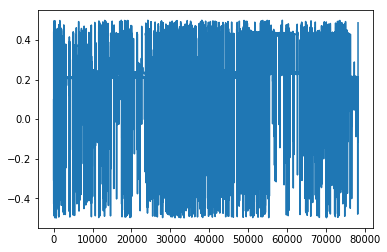

In [55]:
plt.plot(res)

In [36]:
F_forecast.best_parameters

{'d_DECJ': 0,
 'd_RAJ': 0,
 'dbeta': 0,
 'dgamma': 0,
 'f0': 365.95336878765363,
 'ppn_mode': 'heavysimple',
 'shapiro': True,
 'tol': 1e-16,
 'use_quad': False}

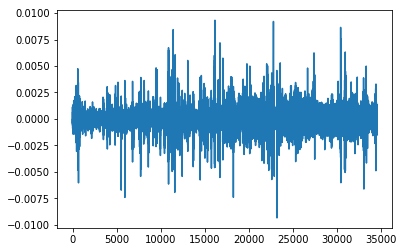

In [53]:
plt.plot(F_forecast.residuals(F_forecast.best_parameters))

In [77]:
mjd_start = 56400
mjd = 0.
span = 30./86400
res_short = []
toas_short = []
freq_short = []
unc_short = []
for r,t in zip(res,toa_info):
    k = t["flags"]["tel"], int(t["flags"]["band"])
    if k!=("AO",1400):
        continue
    if mjd==0 and t["mjd"]>=mjd_start:
        mjd = t["mjd"]
    if mjd<=t["mjd"]<=mjd+span:
        print t["mjd"], t["freq"]
        res_short.append(r)
        toas_short.append(t)
        freq_short.append(t["freq"])
        unc_short.append(t["uncert"]*1e-6/2.7e-3)

56477.5248274 1772.96875
56477.5248274 1762.8125
56477.5248274 1740.15625
56477.5248274 1733.90625
56477.5248274 1727.65625
56477.5248274 1721.40625
56477.5248274 1715.15625
56477.5248274 1708.90625
56477.5248275 1703.12219238
56477.5248274 1665.15625
56477.5248274 1658.90625
56477.5248274 1652.65625
56477.5248274 1646.40625
56477.5248274 1640.15625
56477.5248274 1633.90625
56477.5248274 1596.35742188
56477.5248274 1590.15625
56477.5248274 1583.90625
56477.5248274 1577.82958984
56477.5248274 1571.40625
56477.5248274 1540.15625
56477.5248274 1533.90625
56477.5248274 1527.65625
56477.5248274 1521.40625
56477.5248274 1515.15625
56477.5248274 1483.90625
56477.5248274 1477.65625
56477.5248274 1471.40625
56477.5248274 1465.15625
56477.5248274 1440.15625
56477.5248274 1433.90625
56477.5248274 1429.21875
56477.5248274 1420.625
56477.5248275 1415.15625
56477.5248274 1390.15625
56477.5248274 1383.90625
56477.5248274 1377.65625
56477.5248274 1352.65625
56477.5248274 1346.40625
56477.5248274 1340.

True

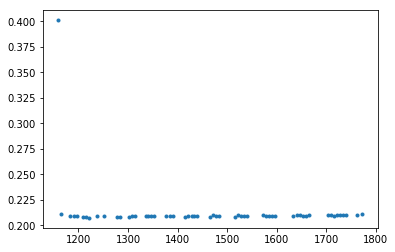

In [88]:
plt.errorbar(freq_short, res_short, unc_short, linestyle="none", marker=".")

np.all(np.diff(freq_short)<0)

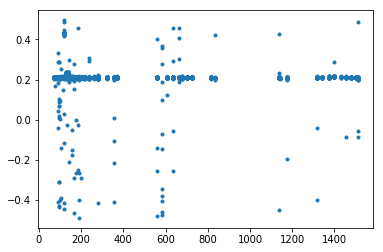

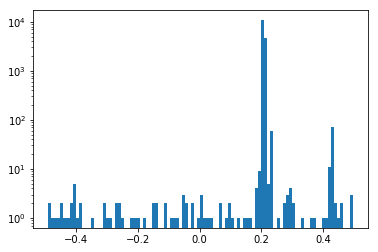

In [91]:
c = np.zeros_like(res,dtype=bool)
for i,t in enumerate(toa_info):
    k = t["flags"]["tel"], int(t["flags"]["band"])
    snr = float(t["flags"]["snr"])*np.sqrt(float(t["flags"]["nbin"]))
    if k==("AO",1400) and snr>10:
        c[i] = True
        
plt.errorbar(F.mjds[c], res[c], F.uncerts[c], linestyle="none", marker=".")
        
plt.figure()
plt.hist(res[c], bins=100)
plt.gca().set_yscale('log',nonposy='clip')

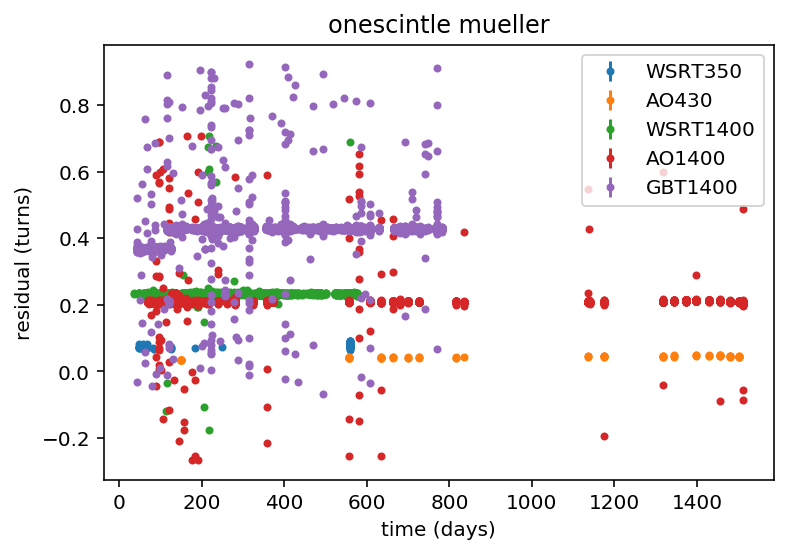

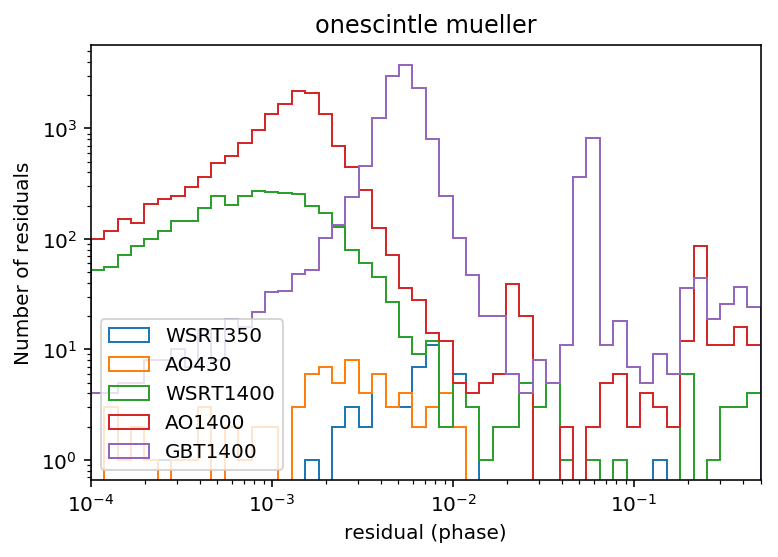

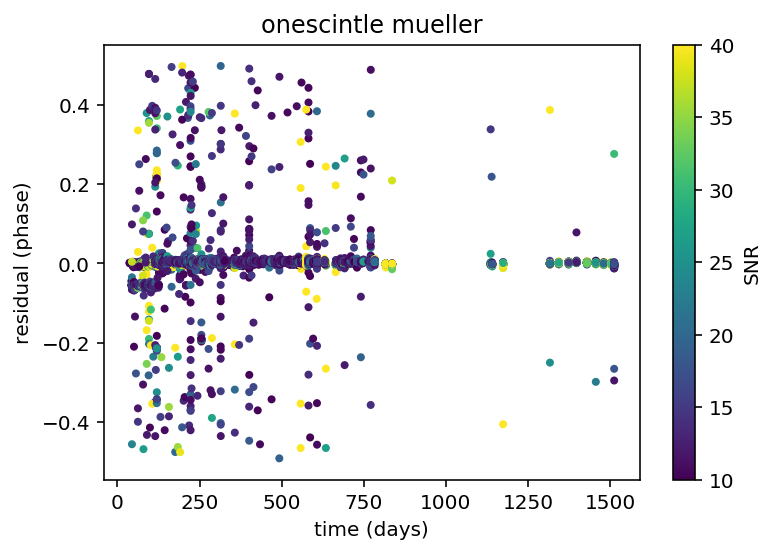

In [134]:
plt.figure(1)
plt.figure(2)
plt.figure(3)

cm = plt.get_cmap("viridis")
cNorm  = matplotlib.colors.Normalize(vmin=10, vmax=40)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)

def key(t):
    return t["flags"]["tel"], int(t["flags"]["band"])
def wrap(a,center=0):
    return (a+0.5-center) % 1 - 0.5 + center
def fmtk(k):
    return "%s%s" % k
subsets = {}
snrs = np.zeros(len(toa_info))

be = 10**np.linspace(np.log10(1e-4),np.log10(0.5),50+1)

for i,t in enumerate(toa_info):
    k = key(t)
    if k not in subsets:
        subsets[k] = np.zeros(len(toa_info),dtype=bool)
    snr = float(t["flags"]["snr"])*np.sqrt(float(t["flags"]["nbin"]))
    snrs[i] = snr
    if snr>10:
        subsets[k][i] = True

for k,c in subsets.items():
    m = scipy.stats.circmean(res[c], high=1)
    r = wrap(res[c],m)
    plt.figure(1)
    plt.errorbar(F.mjds[c], r, F.uncerts[c], linestyle="none", marker=".", label=fmtk(k))
    plt.figure(2)
    plt.hist(np.abs(r-m),histtype="step",range=(0,0.5),bins=be, label=fmtk(k))
    plt.figure(3)
    #colors = [scalarMap.to_rgba(s) for s in snrs[c]]
    plt.scatter(F.mjds[c], r-m, marker=".", c=snrs[c], vmin=10, vmax=40)
    
plt.figure(1)
plt.legend(loc="best")
plt.xlabel("time (days)")
plt.ylabel("residual (turns)")
plt.title("%s %s" % (toa_info[0]["flags"]["processing_name"],toa_info[0]["flags"]["toa_name"]))
plt.savefig("outliers-raw.pdf")
plt.figure(2)
plt.xlim(be[0],be[-1])
plt.legend(loc="lower left")
plt.gca().set_yscale('log',nonposy='clip')
plt.gca().set_xscale('log')             
plt.xlabel("residual (phase)")
plt.ylabel("Number of residuals")
plt.title("%s %s" % (toa_info[0]["flags"]["processing_name"],toa_info[0]["flags"]["toa_name"]))
plt.savefig("outliers-dist.pdf")
plt.figure(3)
plt.title("%s %s" % (toa_info[0]["flags"]["processing_name"],toa_info[0]["flags"]["toa_name"]))
plt.xlabel("time (days)")
plt.ylabel("residual (phase)")
plt.colorbar(label="SNR")
plt.savefig("outliers-snr.pdf")



In [ ]:
for t in toa_info:
    plt.figure(1)
    scalarMap.to_rgba(values[idx])

In [135]:
bins_dict = {}
for i,t in enumerate(toa_info):
    if key(t)!=('GBT',1400):
        continue
    nbin = int(t['flags']['nbin'])
    if nbin not in bins_dict:
        bins_dict[nbin] = []
    bins_dict[nbin].append((t['mjd'],res[i]))

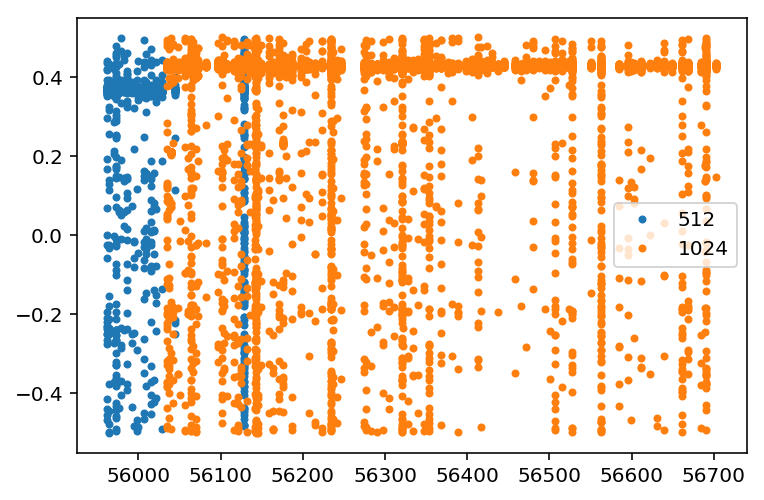

In [137]:
for k,v in bins_dict.items():
    v = np.array(v)
    plt.plot(v[:,0],v[:,1],".",label=str(k))
plt.legend()